In [182]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from collections import Counter
from sklearn.impute import KNNImputer
import os, gc

pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


doris.schioberg  2:58 PM
@channel Due dates and procedure for baseline:
Give a 10 minute presentation on October 27 in class. You don't need to submit anything at this time.
PRESENTATION GUIDELINES
• make it a short 10 min presentation (not everyone has to speak since it is short, but feel free to decide whatever suits your group the best)
• feel free to use slides or python notebooks - Jane
• introduce your group - Jane
• introduce your data set - Jane
• introduce your problem statement - Jane
- missing values
- rotated faces traditionally handled in a certain way with data augmentation
- basic information around CNN for feature extraction 
• tell us how you think you are going to solve the problem (missing values, capsule network for rotated faces) - Jane / Madhu
- EDA for missing values
- capsule network for rotated faces
• the main purpose of the baseline presentation is to make sure that you have met w/ your group and started seriously thinking about the project.
• typically the start of a project involves a good amount of EDA (exploratory data analysis), things like histograms, counts of missing values, etc.
• feel free to spend some time showing what EDA your group did as it is getting started and thinking about the modeling techniques you intend to use. 
• for your baseline presentation, if you have some results from a simple or baseline model, feel free to share results
Make sure you have set up your groups and topics by October 9

**Action Items:**  
- Design draft baseline presentation - Jane
- Finish up outlier and missing value analysis - Jane
- Design RMSE metric for tf 1 - Madhu
- Add early stopping - Madhu
- Add history - Madhu
- Add code to save best model - Madhu


## Functions

In [183]:
def convert_pixels(data):
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [348]:
def view_img(sample_img,coord=None):
    """
    Display an image. For debugging, display a coordinate on the image.
    input:
        - sample_img: numpy array. image to be displayed
        - coord: lst. of coordinates in form [[x_coordinate,y_coordinate],[x_coordinate,y_coordinate]]
    TODO handle multiple coordinates. Work out bugs with multiple coordinates
    """
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    plt.scatter(coord[0],coord[1],marker = '*',c='r')
    plt.show()

## Import data

In [185]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

In [186]:
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()

In [187]:
x_train = convert_pixels(train_data)
x_test = convert_pixels(test_data)

## EDA  
**labels**
1. [ ] Explore imputation strategies  
    - Completed code. Will require running entire model  
    - Perhaps take a look at images that have missing values to determine if there are inherent reasons why this is not valid.  
    - Create a summary slide of common reasons why things are not labeled.  
2. [ ] Explore outlier correction strategies to identify if areas of the face are mislabeled  
3. [ ] Label as -1,-1 to identify cutoff images  

**image**  
1. [ ] Add noise via rotation, flipped image, blurring, etc. Ideally, not have to do any of these for capsule networks  
2. [x] Explore imputation strategies  
    - There are no missing pixels in the training or testing images.  
3. [ ] Add preprocessing for auto-contrast adjustment  

**overall**   
1. [ ] Update to RMSE scoring  
2. [ ] Add code to troubleshoot the most wrongly predicted images to identify images causing large sources of error  

### Explore NA in labels
Based on the below analysis, distributions are fairly normal with some outliers, and mean and median are fairly similar.


Number of columns with any NA value:


True     28
False     3
dtype: int64


Number of images missing coordinates for each feature:


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64


Test skew of each distribution:


[('left_eye_center_x', 'Not normal'),
 ('left_eye_center_y', 'Not normal'),
 ('right_eye_center_x', 'Not normal'),
 ('right_eye_center_y', 'Not normal'),
 ('left_eye_inner_corner_x', 'Not normal'),
 ('left_eye_inner_corner_y', 'Not normal'),
 ('left_eye_outer_corner_x', 'Not normal'),
 ('left_eye_outer_corner_y', 'Not normal'),
 ('right_eye_inner_corner_x', 'Not normal'),
 ('right_eye_inner_corner_y', 'Not normal'),
 ('right_eye_outer_corner_x', 'Not normal'),
 ('right_eye_outer_corner_y', 'Not normal'),
 ('left_eyebrow_inner_end_x', 'Not normal'),
 ('left_eyebrow_inner_end_y', 'Not normal'),
 ('left_eyebrow_outer_end_x', 'Not normal'),
 ('left_eyebrow_outer_end_y', 'Not normal'),
 ('right_eyebrow_inner_end_x', 'Not normal'),
 ('right_eyebrow_inner_end_y', 'Not normal'),
 ('right_eyebrow_outer_end_x', 'Not normal'),
 ('right_eyebrow_outer_end_y', 'Not normal'),
 ('mouth_left_corner_x', 'Not normal'),
 ('mouth_left_corner_y', 'Not normal'),
 ('mouth_right_corner_x', 'Normal'),
 ('mouth_


Compare mean and median of these distribution:


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326


(59.60048407784349, 73.11755841166332)

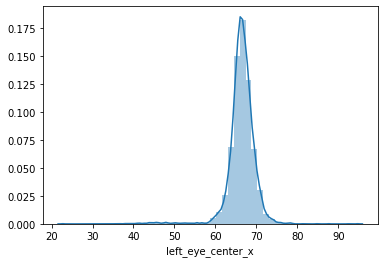

In [237]:
print('\nNumber of columns with any NA value:')
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()

print('\nNumber of images missing coordinates for each feature:')
train_data[columns_nan].isna().sum(axis=0)

print('\nTest skew of each distribution:')
[(col,['Not normal' if stats.skewtest(train_data[col],nan_policy='omit').pvalue < .05 else 'Normal'][0]) for col in columns_nan]

print('\nCompare mean and median of these distribution:')
train_data.describe().loc[['mean','50%']]
sns.distplot(train_data[columns_nan[0]])
(train_data[columns_nan[0]].mean() - 1.96*train_data[columns_nan[0]].std(), train_data[columns_nan[0]].mean() + 1.96*train_data[columns_nan[0]].std())

Use Nearest Neighbors imputation. Takes closest 3 neighbors with the most important neighbor being the closest neighbor (`weights='distance' vs weights='uniform'`).

In [216]:
imputer = KNNImputer(n_neighbors=3, weights='distance')
y_train = imputer.fit_transform(y_train)

Compare imputed value with the actual image


========== Assessing missing feature: left_eye_center ==========
[66.58040658 41.83346233]


IndexError: invalid index to scalar variable.

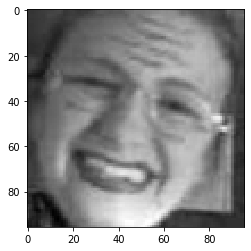

In [318]:
def missing_coord(feature:str):
    """
    Compare missing labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing missing feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    missing_feature = train_data.loc[(train_data[x_coord].isnull()) | (train_data[y_coord].isnull()),
                                 [x_coord,y_coord]]
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(missing_feature.index):
        if enum_ind > 10: print('Too many images missing coordinates. Only printing 10.'); break
        impute_coord = y_train[ind][num_col]
        view_img(x_train[ind],impute_coord)
        print(f'Imputed {feature} coordinates for image {ind}:{impute_coord}\n')

# missing_coord('right_eye_center')
missing_coord('left_eye_center')
missing_coord('mouth_center_top_lip')
missing_coord('left_eyebrow_outer_end')

### Explore NA in images
There are no missing pixels in the training or testing images.

In [192]:
img = [set(row.split(' ')) for row in train_data['Image']]
['' in row for row in img].count(True)

0

In [193]:
img = [set(row.split(' ')) for row in test_data['Image']]
['' in row for row in img].count(True)

0

### Explore outliers in labels


========== Assessing outlier feature: mouth_left_corner ==========

x coordinate confidence interval: (49.009014024382964, 77.56245621759044)

y coordinate confidence interval: (59.94168171451443, 91.99974695715645)


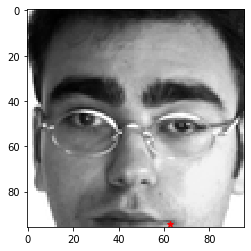

Imputed mouth_left_corner coordinates for image 1230:[62.75768889 94.31217778]



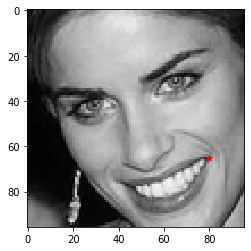

Imputed mouth_left_corner coordinates for image 1595:[79.97278912 65.14557823]



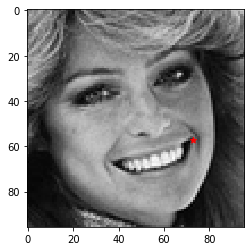

Imputed mouth_left_corner coordinates for image 1635:[73.0584229  57.02325806]



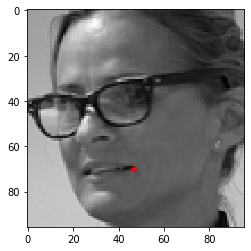

Imputed mouth_left_corner coordinates for image 1649:[46.80754403 69.84717937]



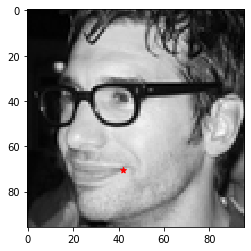

Imputed mouth_left_corner coordinates for image 1652:[42.07374857 70.45793623]



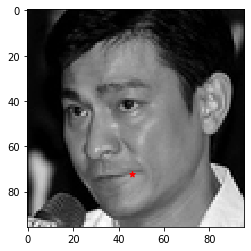

Imputed mouth_left_corner coordinates for image 1723:[46.15482532 72.23521273]



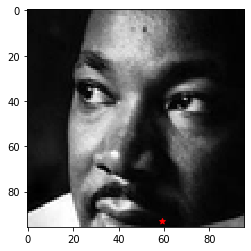

Imputed mouth_left_corner coordinates for image 1784:[59.10097022 92.97236534]



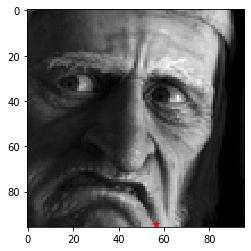

Imputed mouth_left_corner coordinates for image 1808:[56.7241867  94.11759951]



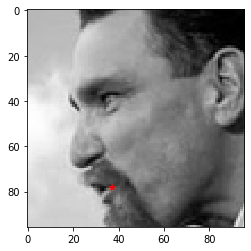

Imputed mouth_left_corner coordinates for image 1861:[37.14546939 78.11134694]



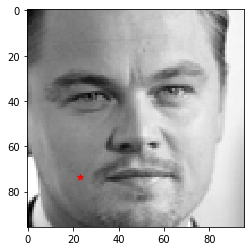

Imputed mouth_left_corner coordinates for image 1907:[22.92336197 73.4839449 ]



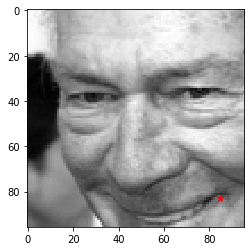

Imputed mouth_left_corner coordinates for image 1927:[84.76712315 82.64243763]

Too many images have outlier coordinates. Only printing 10.


In [351]:
def detect_cutoff(feature:str):
    """
    Compare outlier labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing outlier feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    
    right_bound_y = train_data[y_coord].mean() + 3.5 * train_data[y_coord].std()
    left_bound_y  = train_data[y_coord].mean() - 3.5 * train_data[y_coord].std()    
    
    print(f'\ny coordinate confidence interval: {left_bound_y,right_bound_y}')
    
    outlier_feature = train_data.loc[(train_data[x_coord] <= left_bound_x) | (train_data[x_coord] >= right_bound_x) |
                                     (train_data[y_coord] <= left_bound_y) | (train_data[y_coord] >= right_bound_y),
                                 [x_coord,y_coord]]
    
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(outlier_feature.index):
        if enum_ind > 10: print('Too many images have outlier coordinates. Only printing 10.'); break
        impute_coord = y_train[ind][num_col]
        view_img(x_train[ind],impute_coord)
        print(f'Imputed {feature} coordinates for image {ind}:{impute_coord}\n')
        
outlier_coord('mouth_left_corner')

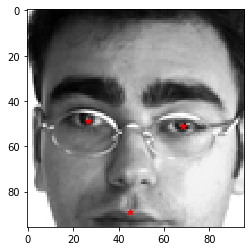

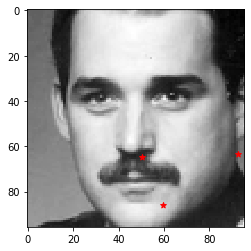

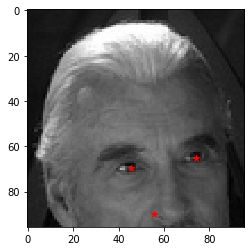

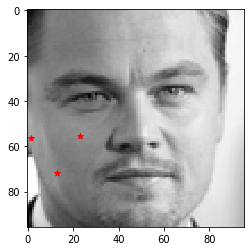

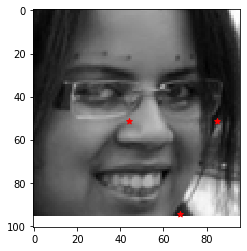

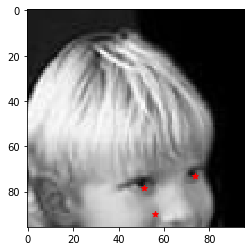

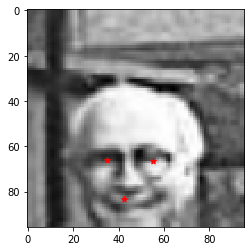

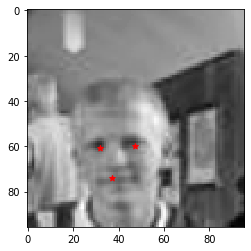

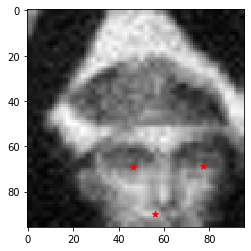

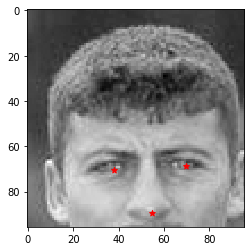

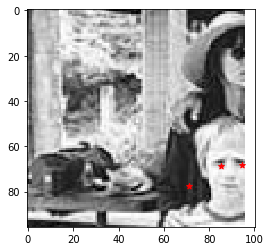

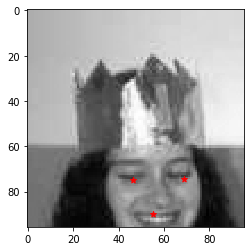

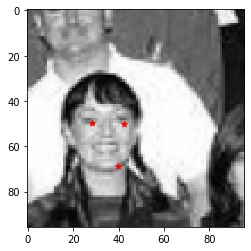

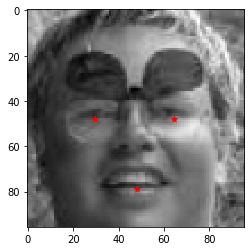

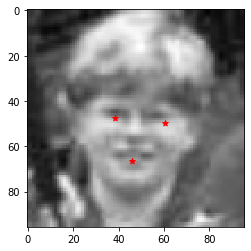

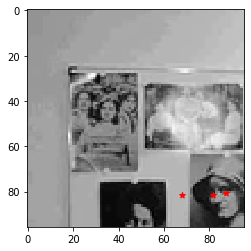

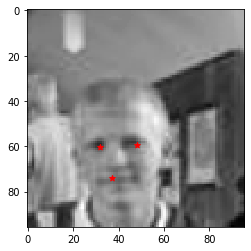

[37.17149369011191, 47.96304]

array([[37.17149369, 74.13099996],
       [47.96304   , 59.2904    ]])

array([[37.17149369, 74.13099996],
       [47.96304   , 59.2904    ]])

In [350]:
# find eyes that are situated lower than average
left_eye_upper_bound  = train_data['left_eye_center_y'].mean()  + 3 * train_data['left_eye_center_y'].std()
right_eye_upper_bound = train_data['right_eye_center_y'].mean() + 3 * train_data['right_eye_center_y'].std()

cutoff_faces = train_data[(train_data['left_eye_center_y'] >= left_eye_upper_bound) & (train_data['right_eye_center_y'] >= right_eye_upper_bound)]

for ind in cutoff_faces.index:
    view_img(x_train[ind],np.array([(y_train[ind][[26,27]]),(y_train[ind][[0,1]]),(y_train[ind][[2,3]])]).T)


[el[0] for el in ([(y_train[ind][[26,27]]),(y_train[ind][[0,1]])])]
np.array([list(y_train[ind][[26,27]]),list(y_train[ind][[0,1]])])
np.array([list(y_train[ind][[26,27]]),list(y_train[ind][[0,1]])])

In [347]:
np.array([(y_train[ind][[26,27]]),(y_train[ind][[0,1]]),(y_train[ind][[2,3]])])
test = np.array([(y_train[ind][[26,27]]),(y_train[ind][[0,1]]),(y_train[ind][[2,3]])]).T
test
test[0]


array([[37.17149369, 74.13099996],
       [47.96304   , 59.2904    ],
       [31.6792    , 60.185104  ]])

array([[37.17149369, 47.96304   , 31.6792    ],
       [74.13099996, 59.2904    , 60.185104  ]])

array([37.17149369, 47.96304   , 31.6792    ])